<a href="https://colab.research.google.com/github/shreevat25/Blockhouse-Work-Trial/blob/main/blackhouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "FROG_2025-05-01 00_00_00+00_00.csv"

df = pd.read_csv(file_path, low_memory=False)

df['minute'] = pd.to_datetime(df['ts_event']).dt.floor('T')

depth = 10
bid_cols = [f'bid_px_0{i}' if i < 10 else f'bid_px_{i}' for i in range(depth)]
ask_cols = [f'ask_px_0{i}' if i < 10 else f'ask_px_{i}' for i in range(depth)]
bid_sz_cols = [f'bid_sz_0{i}' if i < 10 else f'bid_sz_{i}' for i in range(depth)]
ask_sz_cols = [f'ask_sz_0{i}' if i < 10 else f'ask_sz_{i}' for i in range(depth)]

snapshot = df.iloc[0]
for i in range(depth):
    print(f"Bid: {snapshot[bid_cols[i]]} x {snapshot[bid_sz_cols[i]]} | Ask: {snapshot[ask_cols[i]]} x {snapshot[ask_sz_cols[i]]}")


Bid: 34.1 x 100 | Ask: 34.75 x 200
Bid: 33.42 x 100 | Ask: 35.43 x 200
Bid: 33.4 x 200 | Ask: 35.45 x 100
Bid: 33.07 x 900 | Ask: 35.47 x 1
Bid: 32.74 x 100 | Ask: 35.65 x 900
Bid: 32.73 x 100 | Ask: 36.0 x 20
Bid: 32.71 x 900 | Ask: 36.14 x 200
Bid: 32.06 x 100 | Ask: 36.17 x 900
Bid: 32.05 x 5 | Ask: 36.31 x 100
Bid: 32.01 x 15.0 | Ask: 36.4 x 2.0


/tmp/ipython-input-2-3127093181.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = pd.to_datetime(df['ts_event']).dt.floor('T')


Analyzing FROG_2025-05-01 00_00_00+00_00.csv...


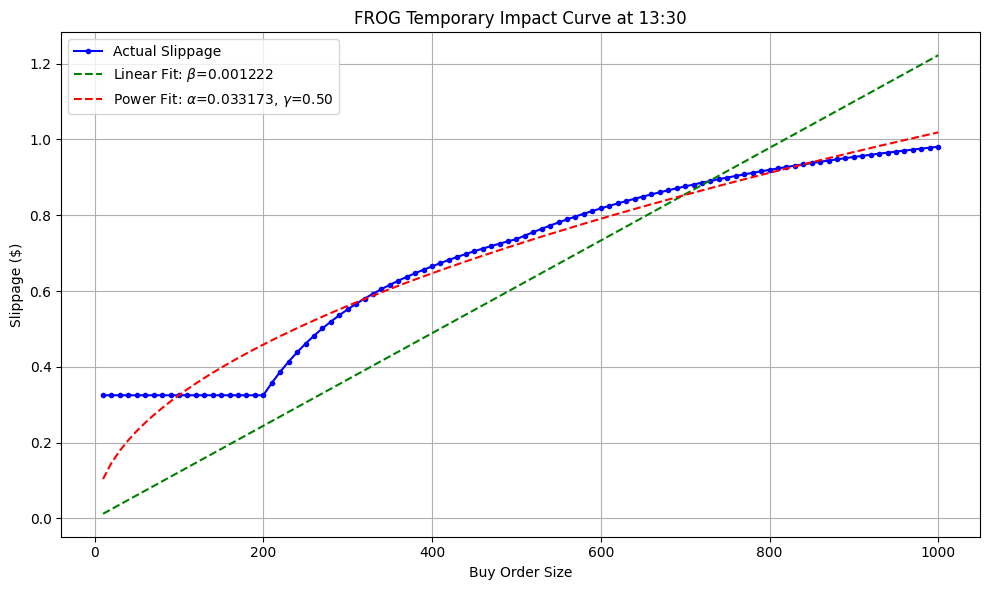

------------------------------
Analyzing CRWV_2025-05-02 00_00_00+00_00.csv...


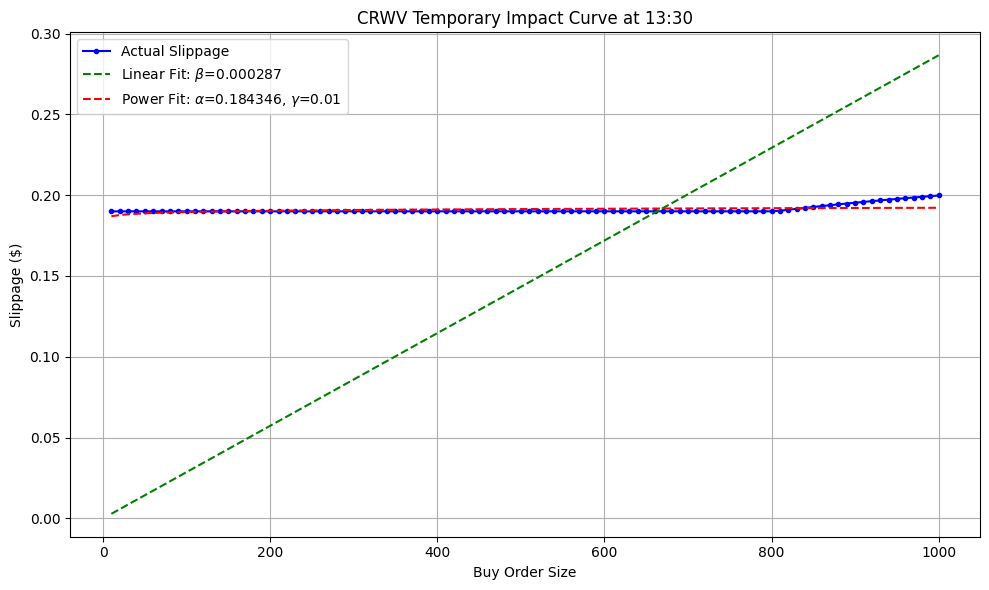

------------------------------
Analyzing /content/SOUN_2025-04-03 00_00_00+00_00.csv...


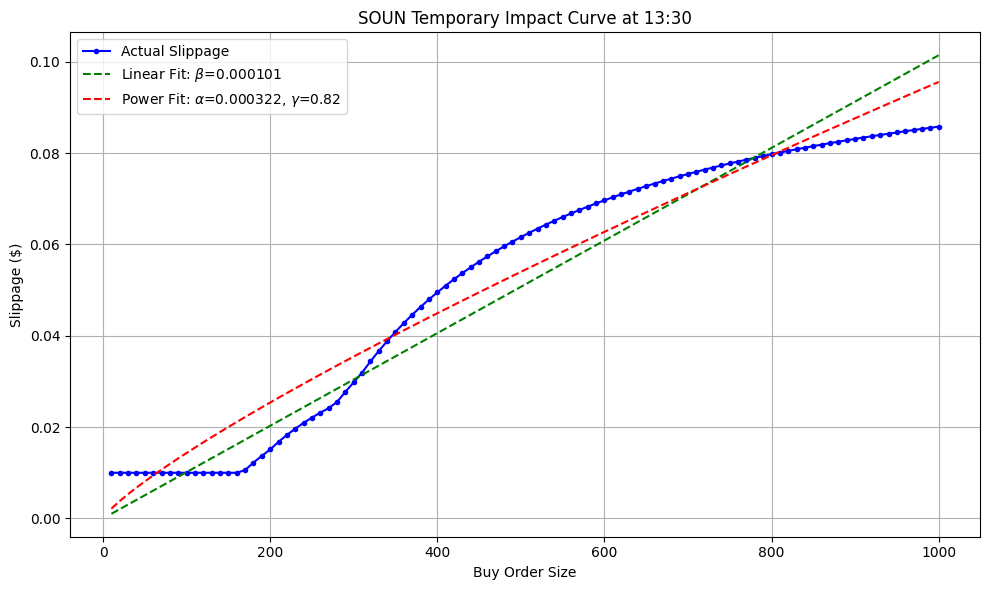

------------------------------

--- Summary of Model Parameters Across Stocks ---
FROG @ 2025-05-01 13:30:00:
    β (Linear) = 0.001222
    α (Power) = 0.033173, γ (Power) = 0.50


CRWV @ 2025-05-02 13:30:00:
    β (Linear) = 0.000287
    α (Power) = 0.184346, γ (Power) = 0.01


SOUN @ 2025-04-03 13:30:00:
    β (Linear) = 0.000101
    α (Power) = 0.000322, γ (Power) = 0.82




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def compute_slippage_from_snapshot(bid_prices, ask_prices, ask_sizes, order_size):
    filled = 0
    cost = 0
    i = 0

    while filled < order_size and i < len(ask_prices):
        size_to_take = min(order_size - filled, ask_sizes[i])
        cost += size_to_take * ask_prices[i]
        filled += size_to_take
        i += 1

    if filled < order_size:
        return np.nan

    avg_price = cost / order_size
    mid_price = (bid_prices[0] + ask_prices[0]) / 2
    return avg_price - mid_price

def linear_model(x, beta):
    return beta * x

def power_model(x, alpha, gamma):
    return alpha * (x ** gamma)

def analyze_snapshot(df, target_minute_dt, ticker_name):
    depth = 10

    snapshot_row = df[df['minute'] == target_minute_dt]

    if snapshot_row.empty:
        print(f"Error: No data found for {ticker_name} at minute {target_minute_dt}. This should not happen if target_minute_dt comes from df.unique(). Skipping analysis.")
        return None

    row = snapshot_row.iloc[0]

    bid_prices = [row[f'bid_px_0{i}'] if i < 10 else row[f'bid_px_{i}'] for i in range(depth)]
    ask_prices = [row[f'ask_px_0{i}'] if i < 10 else row[f'ask_px_{i}'] for i in range(depth)]
    ask_sizes = [row[f'ask_sz_0{i}'] if i < 10 else row[f'ask_sz_{i}'] for i in range(depth)]


    order_sizes = list(range(10, 1001, 10))
    slippages = [compute_slippage_from_snapshot(bid_prices, ask_prices, ask_sizes, x) for x in order_sizes]


    X = np.array(order_sizes)
    Y = np.array(slippages)

    mask = ~np.isnan(Y)
    X_clean = X[mask]
    Y_clean = Y[mask]

    if len(X_clean) < 2:
        print(f"Not enough clean data points ({len(X_clean)}) to fit models for {ticker_name} at minute {target_minute_dt}. Skipping plot and fit.")
        return {
            "minute": target_minute_dt.strftime('%Y-%m-%d %H:%M:%S'),
            "ticker": ticker_name,
            "beta": np.nan,
            "alpha": np.nan,
            "gamma": np.nan
        }

    try:
        popt_lin, _ = curve_fit(linear_model, X_clean, Y_clean, maxfev=10000)
    except RuntimeError:
        popt_lin = [np.nan]
        print(f"Linear fit failed for {ticker_name} at {target_minute_dt}.")

    try:
        popt_pow, _ = curve_fit(power_model, X_clean, Y_clean, p0=[0.0001, 0.5], maxfev=10000)
    except RuntimeError:
        popt_pow = [np.nan, np.nan]
        print(f"Power fit failed for {ticker_name} at {target_minute_dt}.")


    plt.figure(figsize=(10, 6))
    plt.plot(X_clean, Y_clean, label="Actual Slippage", color='blue', marker='o', markersize=3, linestyle='-')

    if not np.isnan(popt_lin[0]):
        plt.plot(X_clean, linear_model(X_clean, *popt_lin), '--', label=f"Linear Fit: $\\beta$={popt_lin[0]:.6f}", color='green')

    if not np.isnan(popt_pow[0]):
        plt.plot(X_clean, power_model(X_clean, *popt_pow), '--', label=f"Power Fit: $\\alpha$={popt_pow[0]:.6f}, $\\gamma$={popt_pow[1]:.2f}", color='red')

    plt.xlabel("Buy Order Size")
    plt.ylabel("Slippage ($)")
    plt.title(f"{ticker_name} Temporary Impact Curve at {target_minute_dt.strftime('%H:%M')}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "minute": target_minute_dt.strftime('%Y-%m-%d %H:%M:%S'),
        "ticker": ticker_name,
        "beta": popt_lin[0] if not np.isnan(popt_lin[0]) else np.nan,
        "alpha": popt_pow[0] if not np.isnan(popt_pow[0]) else np.nan,
        "gamma": popt_pow[1] if not np.isnan(popt_pow[1]) else np.nan
    }

results = []

# FROG Analysis
print("Analyzing FROG_2025-05-01 00_00_00+00_00.csv...")
file_frog = "FROG_2025-05-01 00_00_00+00_00.csv"
try:
    df_frog = pd.read_csv(file_frog, low_memory=False)
    df_frog['minute'] = pd.to_datetime(df_frog['ts_event']).dt.floor('min')
    first_frog_minute = df_frog['minute'].min()
    frog_result = analyze_snapshot(df_frog, first_frog_minute, "FROG")
    if frog_result:
        results.append(frog_result)
except FileNotFoundError:
    print(f"File not found: {file_frog}")
except Exception as e:
    print(f"An error occurred while processing {file_frog}: {e}")
print("-" * 30)


# CRWV Analysis
print("Analyzing CRWV_2025-05-02 00_00_00+00_00.csv...")
file_crwv = "CRWV_2025-05-02 00_00_00+00_00.csv"
try:
    df_crwv = pd.read_csv(file_crwv, low_memory=False)
    df_crwv['minute'] = pd.to_datetime(df_crwv['ts_event']).dt.floor('min')
    first_crwv_minute = df_crwv['minute'].min()
    crwv_result = analyze_snapshot(df_crwv, first_crwv_minute, "CRWV")
    if crwv_result:
        results.append(crwv_result)
except FileNotFoundError:
    print(f"File not found: {file_crwv}")
except Exception as e:
    print(f"An error occurred while processing {file_crwv}: {e}")
print("-" * 30)

# SOUN Analysis
print("Analyzing /content/SOUN_2025-04-03 00_00_00+00_00.csv...")
file_soun = "/content/SOUN_2025-04-03 00_00_00+00_00.csv"
try:
    df_soun = pd.read_csv(file_soun, low_memory=False)
    df_soun['minute'] = pd.to_datetime(df_soun['ts_event']).dt.floor('min')
    first_soun_minute = df_soun['minute'].min()
    soun_result = analyze_snapshot(df_soun, first_soun_minute, "SOUN")
    if soun_result:
        results.append(soun_result)
except FileNotFoundError:
    print(f"File not found: {file_soun}")
except Exception as e:
    print(f"An error occurred while processing {file_soun}: {e}")
print("-" * 30)


print("\n--- Summary of Model Parameters Across Stocks ---")
for r in results:
    print(f"{r['ticker']} @ {r['minute']}:")
    print(f"    β (Linear) = {r['beta']:.6f}")
    print(f"    α (Power) = {r['alpha']:.6f}, γ (Power) = {r['gamma']:.2f}")
    print("\n")


--- Starting intraday market impact analysis for FROG ---
Found 390 unique minutes for FROG.
Processed 50/390 minutes for FROG.
Processed 100/390 minutes for FROG.
Processed 150/390 minutes for FROG.
Processed 200/390 minutes for FROG.
Processed 250/390 minutes for FROG.
Processed 300/390 minutes for FROG.
Processed 350/390 minutes for FROG.
Processed 390/390 minutes for FROG.


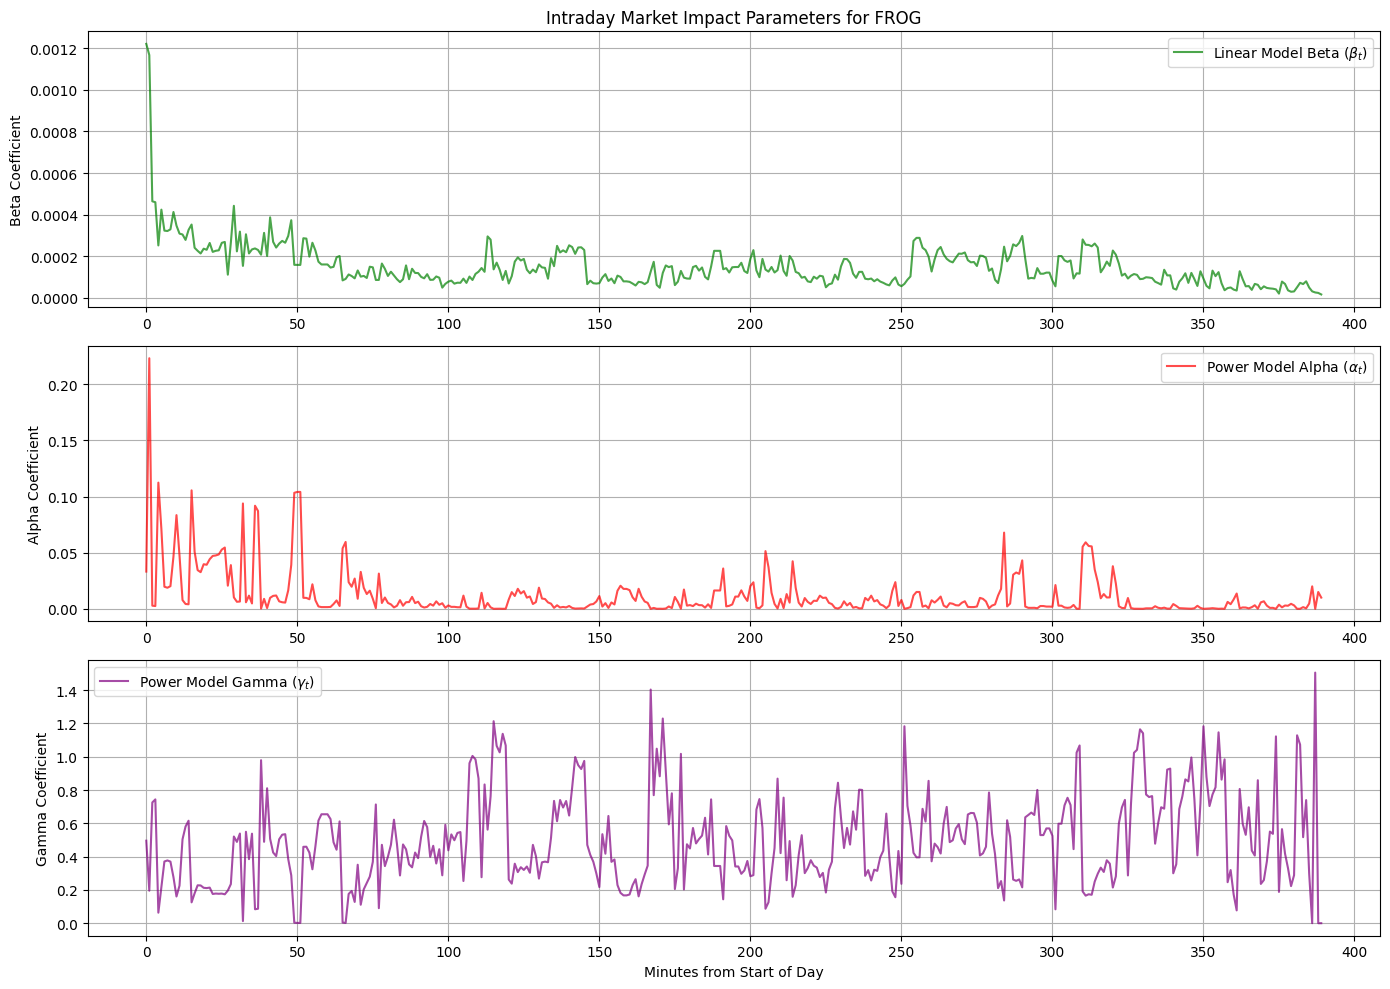


--- Starting intraday market impact analysis for CRWV ---
Found 390 unique minutes for CRWV.
Processed 50/390 minutes for CRWV.
Processed 100/390 minutes for CRWV.
Processed 150/390 minutes for CRWV.
Processed 200/390 minutes for CRWV.
Processed 250/390 minutes for CRWV.
Processed 300/390 minutes for CRWV.
Processed 350/390 minutes for CRWV.
Processed 390/390 minutes for CRWV.


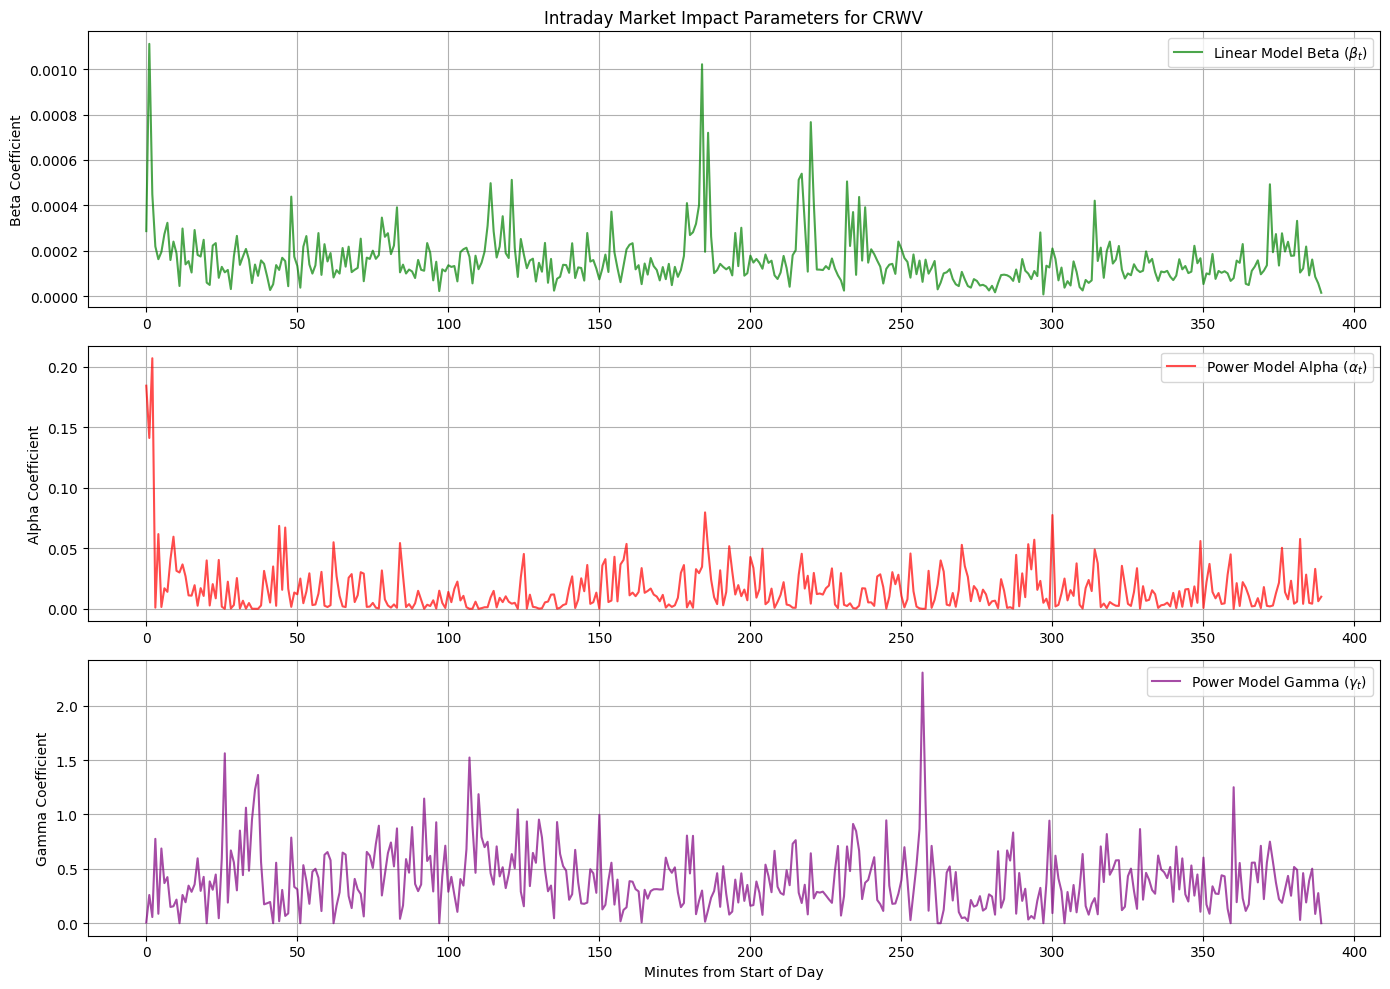


--- Starting intraday market impact analysis for SOUN ---
Found 390 unique minutes for SOUN.
Processed 50/390 minutes for SOUN.
Processed 100/390 minutes for SOUN.
Processed 150/390 minutes for SOUN.
Processed 200/390 minutes for SOUN.
Processed 250/390 minutes for SOUN.
Processed 300/390 minutes for SOUN.
Processed 350/390 minutes for SOUN.
Processed 390/390 minutes for SOUN.


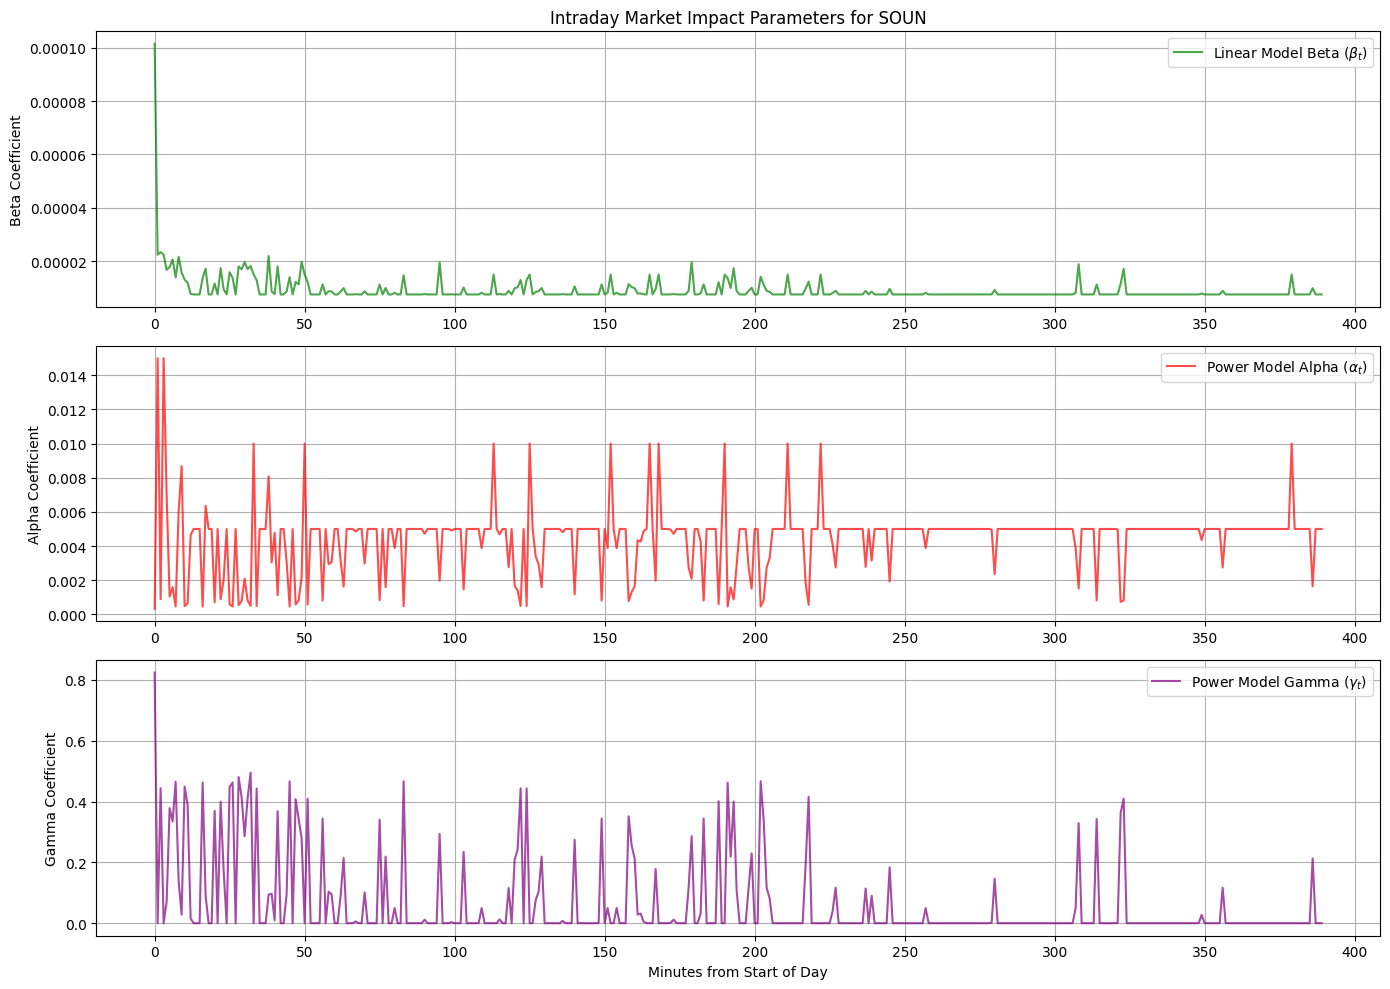


--- All Intraday Analyses Complete ---

--- Summary of Average Intraday Parameters ---
FROG:
    Average β (Linear) = 0.000151
    Average α (Power) = 0.011972, Average γ (Power) = 0.49


CRWV:
    Average β (Linear) = 0.000159
    Average α (Power) = 0.015792, Average γ (Power) = 0.40


SOUN:
    Average β (Linear) = 0.000009
    Average α (Power) = 0.004478, Average γ (Power) = 0.06




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def compute_slippage_from_snapshot(bid_prices, ask_prices, ask_sizes, order_size):
    filled = 0
    cost = 0
    i = 0

    while filled < order_size and i < len(ask_prices):
        size_to_take = min(order_size - filled, ask_sizes[i])
        cost += size_to_take * ask_prices[i]
        filled += size_to_take
        i += 1

    if filled < order_size:
        return np.nan

    avg_price = cost / order_size
    mid_price = (bid_prices[0] + ask_prices[0]) / 2
    return avg_price - mid_price

def linear_model(x, beta):
    return beta * x

def power_model(x, alpha, gamma):

    return alpha * (x ** gamma)

def analyze_snapshot_for_plot(df, target_minute_dt, ticker_name):
    depth = 10
    snapshot_row = df[df['minute'] == target_minute_dt]

    if snapshot_row.empty:
        print(f"Error: No data found for {ticker_name} at minute {target_minute_dt}. Skipping plot.")
        return None

    row = snapshot_row.iloc[0]

    bid_prices = [row[f'bid_px_0{i}'] if i < 10 else row[f'bid_px_{i}'] for i in range(depth)]
    ask_prices = [row[f'ask_px_0{i}'] if i < 10 else row[f'ask_px_{i}'] for i in range(depth)]
    ask_sizes = [row[f'ask_sz_0{i}'] if i < 10 else row[f'ask_sz_{i}'] for i in range(depth)]

    order_sizes = list(range(10, 1001, 10))
    slippages = [compute_slippage_from_snapshot(bid_prices, ask_prices, ask_sizes, x) for x in order_sizes]

    X = np.array(order_sizes)
    Y = np.array(slippages)
    mask = ~np.isnan(Y)
    X_clean = X[mask]
    Y_clean = Y[mask]

    if len(X_clean) < 2:
        print(f"Not enough clean data points ({len(X_clean)}) to fit models for {ticker_name} at minute {target_minute_dt}. Skipping plot and fit.")
        return None

    try:
        popt_lin, _ = curve_fit(linear_model, X_clean, Y_clean, maxfev=10000)
    except RuntimeError:
        popt_lin = [np.nan]

    try:
        popt_pow, _ = curve_fit(power_model, X_clean, Y_clean, p0=[0.0001, 0.5], maxfev=10000)
    except RuntimeError:
        popt_pow = [np.nan, np.nan]

    plt.figure(figsize=(10, 6))
    plt.plot(X_clean, Y_clean, label="Actual Slippage", color='blue', marker='o', markersize=3, linestyle='-')

    if not np.isnan(popt_lin[0]):
        plt.plot(X_clean, linear_model(X_clean, *popt_lin), '--', label=f"Linear Fit: $\\beta$={popt_lin[0]:.6f}", color='green')

    if not np.isnan(popt_pow[0]):
        plt.plot(X_clean, power_model(X_clean, *popt_pow), '--', label=f"Power Fit: $\\alpha$={popt_pow[0]:.6f}, $\\gamma$={popt_pow[1]:.2f}", color='red')

    plt.xlabel("Buy Order Size")
    plt.ylabel("Slippage ($)")
    plt.title(f"{ticker_name} Temporary Impact Curve at {target_minute_dt.strftime('%H:%M')}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "minute": target_minute_dt.strftime('%Y-%m-%d %H:%M:%S'),
        "ticker": ticker_name,
        "beta": popt_lin[0] if not np.isnan(popt_lin[0]) else np.nan,
        "alpha": popt_pow[0] if not np.isnan(popt_pow[0]) else np.nan,
        "gamma": popt_pow[1] if not np.isnan(popt_pow[1]) else np.nan
    }

# Main Analysis Loop for All Stocks
all_intraday_results = {}

tickers_to_analyze = {
    "FROG": "FROG_2025-05-01 00_00_00+00_00.csv",
    "CRWV": "CRWV_2025-05-02 00_00_00+00_00.csv",
    "SOUN": "/content/SOUN_2025-04-03 00_00_00+00_00.csv"
}

for ticker_name, file_path in tickers_to_analyze.items():
    print(f"\n--- Starting intraday market impact analysis for {ticker_name} ---")

    try:
        df = pd.read_csv(file_path, low_memory=False)
        df['minute'] = pd.to_datetime(df['ts_event']).dt.floor('min')
    except FileNotFoundError:
        print(f"Error: File not found: {file_path}. Skipping {ticker_name}.")
        continue
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}. Skipping {ticker_name}.")
        continue

    unique_minutes = sorted(df['minute'].unique())
    print(f"Found {len(unique_minutes)} unique minutes for {ticker_name}.")

    intraday_data = []
    depth = 10

    for i, current_minute_dt in enumerate(unique_minutes):
        snapshot_row = df[df['minute'] == current_minute_dt].iloc[0]

        bid_prices = [snapshot_row[f'bid_px_0{j}'] if j < 10 else snapshot_row[f'bid_px_{j}'] for j in range(depth)]
        ask_prices = [snapshot_row[f'ask_px_0{j}'] if j < 10 else snapshot_row[f'ask_px_{j}'] for j in range(depth)]
        ask_sizes = [snapshot_row[f'ask_sz_0{j}'] if j < 10 else snapshot_row[f'ask_sz_{j}'] for j in range(depth)]

        order_sizes_arr = np.array(list(range(10, 1001, 10)))
        slippages_arr = np.array([compute_slippage_from_snapshot(bid_prices, ask_prices, ask_sizes, x) for x in order_sizes_arr])

        mask = ~np.isnan(slippages_arr)
        X_clean = order_sizes_arr[mask]
        Y_clean = slippages_arr[mask]

        beta_val = np.nan
        alpha_val = np.nan
        gamma_val = np.nan

        if len(X_clean) >= 2:
            try:
                popt_lin, _ = curve_fit(linear_model, X_clean, Y_clean, maxfev=10000)
                beta_val = popt_lin[0]
            except RuntimeError:
                pass

            try:
                popt_pow, _ = curve_fit(power_model, X_clean, Y_clean, p0=[0.0001, 0.5], maxfev=10000)
                alpha_val = popt_pow[0]
                gamma_val = popt_pow[1]
            except RuntimeError:
                pass

        intraday_data.append({
            "minute": current_minute_dt,
            "beta": beta_val,
            "alpha": alpha_val,
            "gamma": gamma_val
        })

        if (i + 1) % 50 == 0 or (i + 1) == len(unique_minutes):
            print(f"Processed {i + 1}/{len(unique_minutes)} minutes for {ticker_name}.")

    intraday_df = pd.DataFrame(intraday_data)
    if not intraday_df.empty:
        intraday_df['minute_of_day'] = (intraday_df['minute'] - intraday_df['minute'].min()).dt.total_seconds() / 60

    all_intraday_results[ticker_name] = intraday_df

    if not intraday_df.empty:
        plt.figure(figsize=(14, 10))

        plt.subplot(3, 1, 1)
        plt.plot(intraday_df['minute_of_day'], intraday_df['beta'], label='Linear Model Beta ($\\beta_t$)', color='green', alpha=0.7)
        plt.title(f'Intraday Market Impact Parameters for {ticker_name}')
        plt.ylabel('Beta Coefficient')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(intraday_df['minute_of_day'], intraday_df['alpha'], label='Power Model Alpha ($\\alpha_t$)', color='red', alpha=0.7)
        plt.ylabel('Alpha Coefficient')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(intraday_df['minute_of_day'], intraday_df['gamma'], label='Power Model Gamma ($\gamma_t$)', color='purple', alpha=0.7)
        plt.xlabel('Minutes from Start of Day')
        plt.ylabel('Gamma Coefficient')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print(f"No intraday data to plot for {ticker_name}.")

print("\n--- All Intraday Analyses Complete ---")
print("\n--- Summary of Average Intraday Parameters ---")
for ticker, df_results in all_intraday_results.items():
    if not df_results.empty:
        avg_beta = df_results['beta'].mean()
        avg_alpha = df_results['alpha'].mean()
        avg_gamma = df_results['gamma'].mean()
        print(f"{ticker}:")
        print(f"    Average β (Linear) = {avg_beta:.6f}")
        print(f"    Average α (Power) = {avg_alpha:.6f}, Average γ (Power) = {avg_gamma:.2f}")
        print("\n")
    else:
        print(f"{ticker}: No data to summarize.")